## Building Chatbot with Multiple Tools Using Langgrahph

# Aim

create a chatbot with tool capabilities from arxiv,wikipedia search and some functions

In [2]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper ,ArxivAPIWrapper

In [3]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [4]:
arxiv.invoke("attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [6]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [7]:
wiki.invoke('what is machine learning')

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [8]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


In [10]:
## Tavily search tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily=TavilySearchResults()

In [11]:
tavily.invoke("provide me the recent july 16 2025 Ai articles")

[{'title': 'AI Dispatch: Daily Trends and Innovations – July 16, 2025 | NVIDIA ...',
  'url': 'https://hipther.com/latest-news/2025/07/15/95652/ai-dispatch-daily-trends-and-innovations-july-16-2025-nvidia-the-guardian-x-ai-the-economist-jumptuit/',
  'content': '1. NVIDIA CEO Promotes AI in D.C. and China · 2. The Rise of the Machines: AI Outrage in Tennis · 3. X.ai Launches Government AI Hub · 4. AI Is',
  'score': 0.7746691},
 {'title': 'Latest AI Breakthroughs and News: May, June, July 2025',
  'url': 'https://www.crescendo.ai/news/latest-ai-news-and-updates',
  'content': 'Summary: Scientists have used AI to develop a new paint formula that keeps buildings significantly cooler by reflecting solar radiation. The',
  'score': 0.47227025},
 {'title': 'Meta and AWS are teaming up to win over developers in the AI race',
  'url': 'https://www.cnn.com/2025/07/16/tech/meta-aws-llama-ai-startups-partnership',
  'content': "Meta CEO Mark Zuckerberg speaks at LlamaCon 2025, the company's AI d

## Combine all the tools in the list



In [12]:
tools=[arxiv,wiki,tavily]

In [14]:
## Initialize the LLm model
from langchain_groq import ChatGroq
llm=ChatGroq(model="qwen/qwen3-32b")
llm_with_tools=llm.bind_tools(tools)



In [15]:
from pprint import pprint
from langchain_core.messages import AIMessage ,HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"what is recent developments in Ai")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking about recent developments in AI. I need to figure out which tool to use here. Let\'s see, the available tools are arxiv, wikipedia, and tavily_search_results_json.\n\nArxiv is good for academic papers, which might give the latest research. Wikipedia could provide a more general overview. Tavily might be a search engine, but I\'m not sure. The user wants recent developments, so maybe arxiv would be best for the latest studies. Let me check the parameters. All require a query. \n\nI should structure the query to get the most recent papers. Maybe use keywords like "recent advancements in AI" or "latest AI developments 2023". Let me go with arxiv for this. The function name is arxiv, and the arguments should have the query. So, I\'ll set the query to "recent developments in AI 2023" to get the latest results.\n', 'tool_calls': [{'id': 'sr79sg34z', 'function': {'arguments': '{"query":"recent developments

In [17]:
llm_with_tools.invoke([HumanMessage(content=f"what is recent developments in Ai")]).tool_calls

[{'name': 'arxiv',
  'args': {'query': 'recent developments in AI'},
  'id': 'xvk519v3p',
  'type': 'tool_call'}]

In [18]:
## State schema

from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]
    

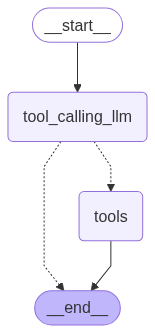

In [28]:
## Entire Chatbot with langgraph

from IPython.display import Image ,display
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode ,tools_condition

## Node defination

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}
## Build graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node('tools',ToolNode(tools))
builder.add_edge(START ,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)

builder.add_edge("tools",END)

graph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
messages=graph.invoke({"messages":HumanMessage(content="provide me the AI latest articles")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

provide me the AI latest articles
================================== Ai Message ==================================
Tool Calls:
  arxiv (kj9tqphs8)
 Call ID: kj9tqphs8
  Args:
    query: AI
================================= Tool Message =================================
Name: arxiv

Published: 2024-08-26
Title: AI Thinking: A framework for rethinking artificial intelligence in practice
Authors: Denis Newman-Griffis
Summary: Artificial intelligence is transforming the way we work with information
across disciplines and practical contexts. A growing range of disciplines are
now involved in studying, developing, and assessing the use of AI in practice,
but these disciplines often employ conflicting understandings of what AI is and
what is involved in its use. New, interdiscipl


In [30]:
messages=graph.invoke({"messages":HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (9t9ea8py6)
 Call ID: 9t9ea8py6
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base
